## simple example
GaussianKernel -> Dense  

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

### create sample data

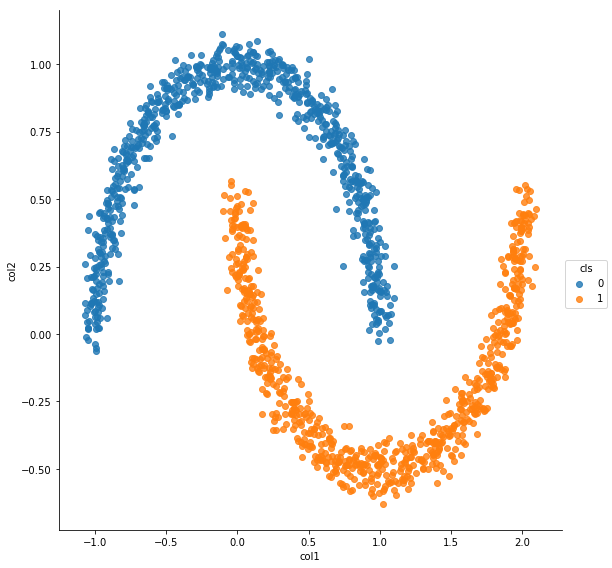

In [4]:
n_samples = 1500

X, y = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=0)
df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = y

sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=8)

### create model

In [5]:
np.random.seed(1)
num_lm = 10
def make_modelz(gamma=0, gamma_svm=0.1, name='DUMMY'):
    inp = Input(shape=(2,), name='inp')
    oup = inp
    model_2 = Model(inp, oup)
    
    oup_gk1 = GaussianKernel(num_lm, 2, kernel_gamma=1/(2*2*0.1), name='gkernel1')(oup)
    model_gk1 = Model(inp, oup_gk1)
    
    oup = Dense(1, activation='sigmoid')(oup_gk1)
    
    model = Model(inp, oup)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return {
        'model': model,
        'model_gk1': model_gk1,
    }

models = make_modelz()
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 2)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel)    (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


### plot sample data and landmarks

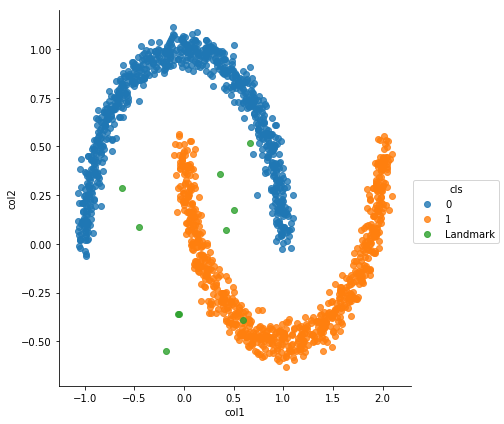

In [6]:
wgt = model.get_layer('gkernel1').get_weights()[0]
df = pd.DataFrame(np.vstack([X, wgt]))
df.columns = ["col1", "col2"]
df['cls'] = [str(ee) for ee in y] + ['Landmark']*wgt.shape[0]
sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=6)

### train

In [7]:
model.fit(X, y, verbose=0,
          batch_size=32,
          epochs=150)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### predict

In [8]:
y_pred = model.predict(X)

# estimated correctly
np.c_[y, 0.5<y_pred]

array([[0, 0],
       [0, 0],
       [1, 1],
       ..., 
       [1, 1],
       [0, 0],
       [0, 0]])

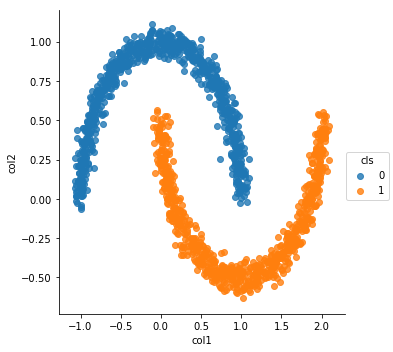

In [9]:
df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = (0.5<y_pred[:,0]).astype(int)
sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False)

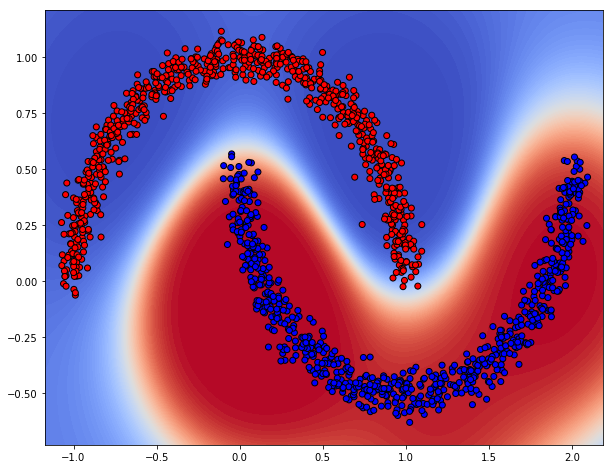

In [10]:
h = .01
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=1024)

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
y_pred = y_pred.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')

### plot output of GaussianKernel layer #1

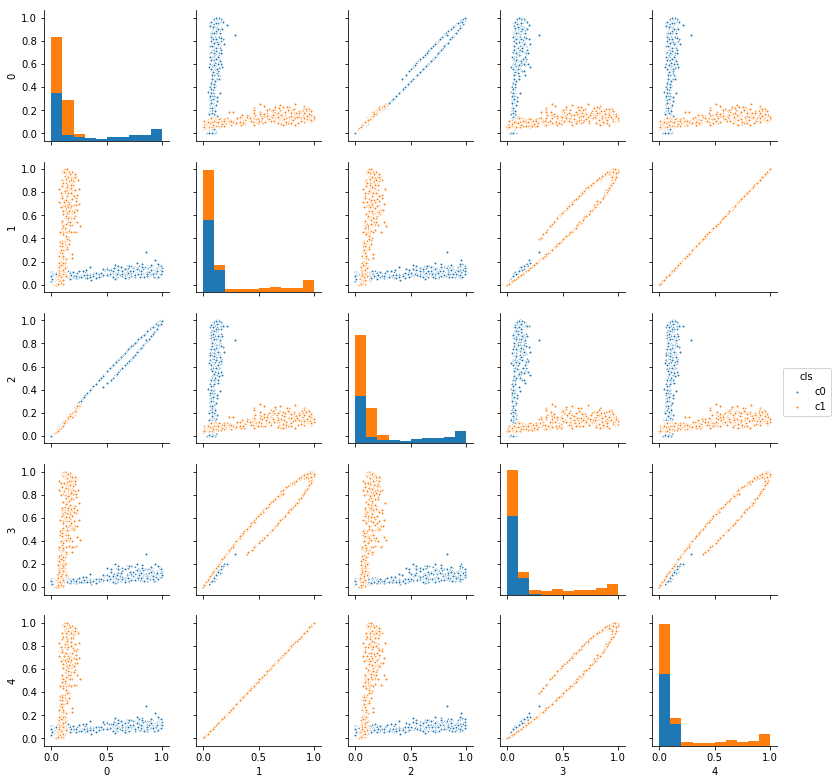

In [11]:
gk1_pred = models['model_gk1'].predict(X, batch_size=1024)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

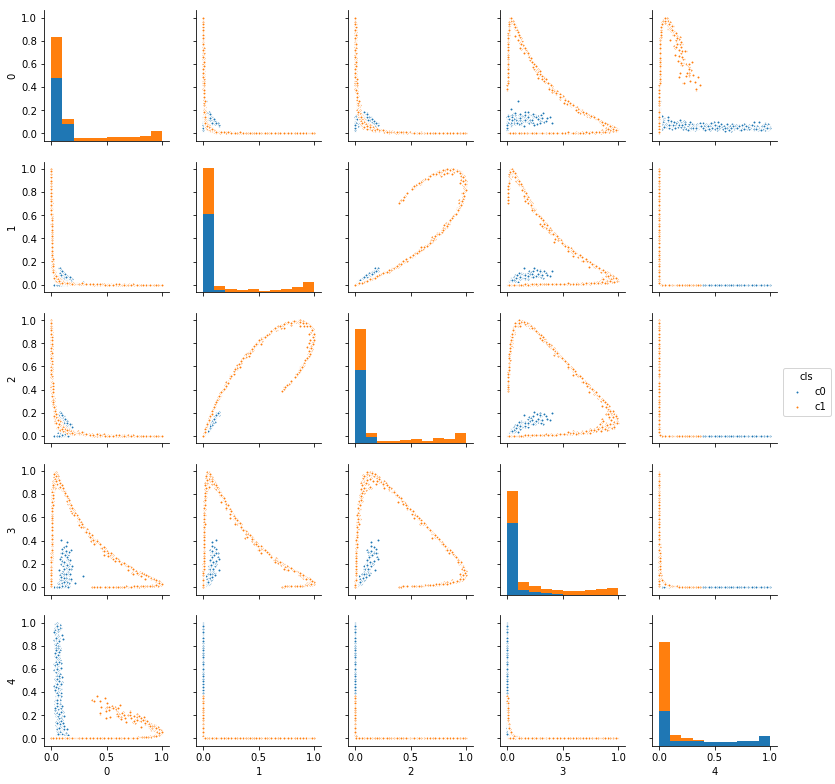

In [12]:
df = pd.DataFrame(gk1_pred[:,5:10])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)